In [9]:
#imports
import numpy as np
import splat
import pandas as pd
import glob
from astropy.io import ascii
import matplotlib.pyplot as plt
from tqdm import tqdm
splat.initializeStandards()
import seaborn as sns
import popsims
splat.initializeStandards(all=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
%matplotlib inline


In [10]:
ABS_MAG_FILE=popsims.DATA_FOLDER+'/absmag_relations.pkl'

In [11]:
#df=  popsims.make_systems(nsample=int(1e7))

In [12]:
#_= plt.hist(df.age.values)

In [13]:
#gfhj

In [14]:
 KVALS={'2MASS_KS': {\
            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
            'rms': np.zeros(65)+0.05}}

In [15]:
sptgrid=np.arange(10, 41, 100)

In [16]:
from popsims.filtermags import filterMag

In [17]:
def get_colors(sp, flt, filt_2mass):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = filterMag(sp.wave, sp.flux, sp.noise, sp.flux.unit, flt)
    #calculate the mag of the standard in J and H
    mag_2mass, mag_unc2mass = filterMag(sp.wave, sp.flux, sp.noise, sp.flux.unit, filt_2mass)
    #calculate the offset 
    return mag_2mass-mag, (mag_unc**2+ mag_unc2mass**2)**0.5

def get_colors_splat(sp, flt, filt_2mass):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    mag_2mass, mag_unc2mass = splat.filterMag(sp, filt_2mass)
    #calculate the offset 
    return mag_2mass-mag, (mag_unc**2+ mag_unc2mass**2)**0.5

In [18]:
sp=splat.getSpectrum(lucky=True)[0]


Retrieving 1 lucky file



In [19]:
get_colors(sp, 'VISTA_KS', '2MASS J')

(0.7986175769101909, 0.07058794473511626)

In [20]:
#ghjbk

In [21]:
#load spectra, ignore binaries, objects with high uncertainty in mag and objects without parallaxes
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False, binary=False)
splat_db['SHORTNAME']=splat_db.DESIGNATION.apply(lambda x: splat.designationToShortName)
sml=splat_db[~ ((splat_db.H_2MASS_E > 0.5) | (splat_db.J_2MASS_E > 0.5)) ]

#sds=sml[(sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd')  ]
sml=sml[~((sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd') \
          | (sml.MEDIAN_SNR <20))]

In [22]:
#verified list of sds


In [23]:
#get y dwarfs
def get_shortname(n):
        return splat.designationToShortName(n).replace('J', 'WISE')

schn='/Volumes/Lacie/schneider/*.txt'
schntb=pd.read_csv('/Volumes/Lacie/wispsdata/data/schneider2015.txt', 
                   delimiter=' ').drop(columns='Unnamed: 14')
schntb['shortname']=schntb.Name.apply(get_shortname)
spectra_schn=[]
for f in glob.glob(schn):
    d=ascii.read(f).to_pandas()
    shortname=(f.split('/')[-1]).split('.txt')[0]
    s=splat.Spectrum(wave=d.col1, 
                     flux=d.col2,
                     noise=d.col3, 
                     name=shortname)
    #measure snr 
    mask= np.logical_and(d.col1>1.0, d.col1<2.4)
    snr= (np.nanmedian(d.col2[mask]/d.col3[mask]))
    spectra_schn.append([s, snr])

In [24]:
mdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum) <20)]
ldwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(20, 30))]
tdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(30, 40))]

In [25]:
#tighter_constraints on m dwarfs 
mdwarfs=mdwarfs[(~mdwarfs.PARALLAX.isna()) & (mdwarfs.MEDIAN_SNR >100)]
ldwarfs=ldwarfs[ (ldwarfs.MEDIAN_SNR >70)]

In [26]:
def choose_ten(df):
    if len(df) >10:
        return df.sort_values('MEDIAN_SNR', ascending=False)[:10]
    else:
        return df

In [27]:
#tdwarfs.MEDIAN_SNR

In [28]:
ls=ldwarfs.groupby('SPEX_TYPE').apply(choose_ten).reset_index(drop=True)#.groupby('SPEX_TYPE').count()

In [29]:
smlf=pd.concat([mdwarfs, ls, tdwarfs]).reset_index(drop=True)

In [30]:
def get_file(x):
    try:
        return splat.getSpectrum(filename=x)[0]
    except:
        return 

In [31]:
%%capture
templs=smlf.DATA_FILE.apply(lambda x: get_file(x))
#sds_spectra=sds.DATA_FILE.apply(lambda x:  get_file(x))


#all_spectra=pd.read_pickle('/users/caganze/research/popsims/data/splat_spectra.pkl')
#sd_spectra=pd.read_pickle('/users/caganze/research/popsims/data/sd_spectra.pkl')

In [32]:
#schntb['spectra']=[x[0] for x in  spectra_schn]

#schntb['snr']=[x[1] for x in  spectra_schn]

#schntb=schntb[schntb.snr>=2.].reset_index(drop=True)

#all_spectra=np.concatenate([templs,schntb.spectra.values ])
all_spectra=templs

In [33]:
#import pickle
#output = open('/users/caganze/research/popsims/data/splat_spectra.pkl', 'wb')
#pickle.dump(all_spectra, output)
#output.close()

#import pickle
#output = open('/users/caganze/research/popsims/data/sd_spectra.pkl', 'wb')
#pickle.dump(sds_spectra, output)
#output.close()


In [34]:
def make_spt_number(spt):
    ##make a spt a number
    if isinstance(spt, str):
        return splat.typeToNum(spt)
    else:
        return spt

In [35]:
#spts=np.concatenate([smlf.SPEX_TYPE.apply(make_spt_number).values,
#                     schntb.Spec.apply(make_spt_number).values,
#                    ])
spts=smlf.SPEX_TYPE.apply(make_spt_number).values

In [36]:
assert len(spts) == len(all_spectra)

In [37]:
#ascii.write?

In [38]:
#for f in glob.glob('/volumes/LaCie/popsimsdata/popsims/filters/*.dat'):
#    d=ascii.read(f,names=['LAM', 'TRANSMISSION'])
#    d['LAM']=d['LAM']/10_000
    #print (d)
#    ascii.write(d, f.replace('.dat', '.txt'), comment='#')
#    plt.plot(d['LAM'], d['TRANSMISSION'])
#    del d
    

In [39]:
#sds_spts=sds.SPEX_TYPE.apply(make_spt_number).values

In [40]:
dwarf_pairs={'NIRISS_F115W': {'ref': '2MASS J', 'method':'ab'},
            'NIRISS_F150W': {'ref': '2MASS H', 'method': 'ab'},
            'NIRISS_F200W': {'ref': '2MASS H', 'method': 'ab'},
            'VISTA_Z':{'ref': 'PANSTARRS_Z', 'method': 'vega'},
            'VISTA_Y':{'ref': 'PANSTARRS_Y', 'method': 'vega'},
            'VISTA_J':{'ref': '2MASS J', 'method': 'vega'},
            'VISTA_H':{'ref': '2MASS H', 'method': 'vega'},
            'VISTA_KS':{'ref': '2MASS H', 'method': 'vega'},
            'UKIDSS_Z':{'ref': 'PANSTARRS_Z', 'method': 'vega'},
            'UKIDSS_J':{'ref': '2MASS J', 'method': 'vega'},
            'UKIDSS_H':{'ref': '2MASS H', 'method': 'vega'},
            'UKIDSS_K':{'ref': '2MASS H', 'method': 'vega'}}


sd_pairs= {'NIRISS_F115W': {'ref': '2MASS J', 'method':'ab'},
            'NIRISS_F150W': {'ref': '2MASS H', 'method': 'ab'},
            'NIRISS_F200W': {'ref': '2MASS H', 'method': 'ab'},
            'VISTA_Z':{'ref': 'SDSS_Z', 'method': 'vega'},
            'VISTA_Y':{'ref': 'SDSS_Z', 'method': 'vega'},
            'VISTA_J':{'ref': '2MASS J', 'method': 'vega'},
            'VISTA_H':{'ref': '2MASS H', 'method': 'vega'},
            'VISTA_KS':{'ref': '2MASS K', 'method': 'vega'},
            'UKIDSS_Z':{'ref': 'SDSS_Z', 'method': 'vega'},
            'UKIDSS_J':{'ref': '2MASS J', 'method': 'vega'},
            'UKIDSS_H':{'ref': '2MASS H', 'method': 'vega'},
            'UKIDSS_K':{'ref': '2MASS K', 'method': 'vega'}}


In [41]:
#sd_absolute_mag(spt, 20)

In [42]:
splat.typeToNum

<function splat.utilities.typeToNum(inp, subclass='dwarf', error='', uncertainty=0.0, luminosity_class='', metallicity_class='', age_class='', color_class='', peculiar=False, verbose=False, **kwargs)>

In [43]:
#remove nones
nones= np.array(all_spectra)==None
all_spectra=all_spectra[~nones]
spts=spts[~nones]
assert len(spts) == len(all_spectra)

In [44]:
def compute_colors(sp, sd=False):
    fl_pairs=None
    if sd: fl_pairs=sd_pairs
    if not sd: fl_pairs=dwarf_pairs
    #sp.normalize()
    res={}
    for p in fl_pairs.keys():
        res.update({p+'and'+fl_pairs[p]['ref']: \
                    get_colors(sp, p, fl_pairs[p]['ref'])})
    return res

In [45]:
zhang_subds=pd.read_pickle( '/volumes/LaCie/popsimsdata/combined_sd_templates.pkl')
zhang_subds['spt']=zhang_subds.sptype.apply(make_spt_number)

In [46]:
optical_stds=pd.read_pickle('/volumes/LaCie/popsimsdata/combined_optical_templates.pkl')
optical_stds['spt']=optical_stds.sptype.apply(make_spt_number)

In [47]:
#darf_pairs

In [48]:
#optical_stds

In [49]:
#only pick those ith sds or esd or usd in their sptype
zhang_subds=zhang_subds[np.logical_or.reduce([zhang_subds.sptype.str.startswith('esd'),\
                                             zhang_subds.sptype.str.startswith('sd'),\
                                              zhang_subds.sptype.str.startswith('usd')])]
#add 
optical_sd_bool=np.logical_or.reduce([optical_stds.sptype.str.startswith('esd'),\
                                    optical_stds.sptype.str.startswith('sd'),\
                                    optical_stds.sptype.str.startswith('usd')]).astype(bool)


In [50]:
zhang_subds=zhang_subds.append(optical_stds[optical_sd_bool])

In [51]:
#assert len(zhang_subds)==131

In [52]:
#zhang_subds.spt.values

In [53]:
#sd_df

In [54]:
optical_templates=optical_stds[~optical_sd_bool].spectra.values
optical_spts=optical_stds[~optical_sd_bool].spt.values

In [55]:
optical_templates=optical_templates[optical_spts>=10]
optical_spts=optical_spts[optical_spts>=10]

assert len(np.concatenate([optical_templates, all_spectra]))==\
len(np.concatenate([optical_spts, spts]))

In [56]:
sd_df=pd.DataFrame.from_records([compute_colors(x, sd=True) for x in tqdm(zhang_subds.spectra.values)])
sd_df['spt']=zhang_subds.spt.values

100%|█████████████████████████████████████████| 133/133 [00:24<00:00,  5.35it/s]


In [57]:
len(all_spectra)

261

In [58]:
df=pd.DataFrame.from_records([compute_colors(x, sd=False) for x in tqdm(np.concatenate([all_spectra, optical_templates]))])
df['spt']=np.concatenate([spts,  optical_spts])

100%|█████████████████████████████████████████| 303/303 [02:53<00:00,  1.75it/s]


In [59]:
df.head(5)

,NIRISS_F115Wand2MASS J,NIRISS_F150Wand2MASS H,NIRISS_F200Wand2MASS H,VISTA_ZandPANSTARRS_Z,VISTA_YandPANSTARRS_Y,VISTA_Jand2MASS J,VISTA_Hand2MASS H,VISTA_KSand2MASS H,UKIDSS_ZandPANSTARRS_Z,UKIDSS_Jand2MASS J,UKIDSS_Hand2MASS H,UKIDSS_Kand2MASS H,spt
0,"(-1.0380377993196443, 0.0036375930541762114)","(-1.5426484969851586, 0.004429305679745099)","(-1.5609495658713755, 0.00533349891922145)","(0.5696960504739934, 0.01083110293290596)","(0.8023156096179029, 0.006443475798088214)","(0.04650997984814431, 0.003277446129070926)","(-0.03308989040901267, 0.00399612683114322)","(0.34112482742130723, 0.0048851419063881294)","(0.6145935317977624, 0.010937491812155387)","(0.05224132591834518, 0.0033453029909885296)","(-0.04749111363173952, 0.0036811271886754227)","(0.4006581683577206, 0.004228392343026027)",18.0
1,"(-0.9821544803935467, 0.004985238402113319)","(-1.4510450477233743, 0.0037073396318551)","(-1.5828818357377141, 0.005280083369808545)","(0.5409836151771508, 0.01951153761057872)","(0.7160323924435694, 0.009294425045929292)","(0.03626774975765912, 0.004050570024433918)","(-0.020984486634864297, 0.0034505421597153434)","(0.23549738986644897, 0.004155493534388487)","(0.5665391906408495, 0.020434436833454816)","(0.037252205005032124, 0.004091390059864661)","(-0.03147766490102022, 0.0032737173135371773)","(0.2791544629660656, 0.003944797650063199)",15.0
2,"(-1.0812994474405038, 0.00878725424621763)","(-1.5743586145894, 0.010969764645373426)","(-1.5127650899200518, 0.014032480474709584)","(0.591558489467122, 0.06454152246147953)","(0.8282149447611467, 0.019622172917895593)","(0.04959918976112121, 0.008706747097898261)","(-0.033889824318361406, 0.010345147972397658)","(0.4083775902411588, 0.012926498237472245)","(0.6446435961708481, 0.06069895983440844)","(0.05537922992494515, 0.00866258654674762)","(-0.04932207243706799, 0.010457860583101851)","(0.467482256980869, 0.012938948999188744)",19.0
3,"(-0.9573179356479429, 0.006913392949634878)","(-1.431761097811311, 0.003189476604740734)","(-1.560874490881142, 0.008280384593311318)","(0.5288781610532851, 0.01265062009113295)","(0.6537078772665517, 0.010740906066571368)","(0.03177590026387733, 0.006367554800236701)","(-0.01853449625739856, 0.002053141624669252)","(0.18465520497437637, 0.004782873126240139)","(0.5457357977909965, 0.01201631782749121)","(0.031206745759016385, 0.0058908803480661005)","(-0.028225556861764645, 0.0018591948645074448)","(0.19783429176922596, 0.005144966951931946)",12.0
4,"(-1.0480453980279023, 0.004644766508206281)","(-1.5419004735053115, 0.005197616395410028)","(-1.5363651102716247, 0.006608386191782572)","(0.5699331712644735, 0.015492976649092858)","(0.8097713141646032, 0.007964870413392073)","(0.044603101108673826, 0.004279243515651158)","(-0.03302261993111699, 0.005181404006830535)","(0.35992615331019806, 0.006439249893362337)","(0.615437085958682, 0.01519900049086973)","(0.0491896652267485, 0.004607918148695202)","(-0.04766837369399468, 0.004934280076160064)","(0.42330085818271357, 0.006444187235541714)",18.0


In [60]:
#ghj

In [61]:
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=3.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

In [62]:
rocio_coeffs={'SDSS_R':[-0.03, 1.3 , 7.2 , 0.62],\
              'SDSS_I':[-0.009, 0.9, 6.8, 0.55],\
              'SDSS_Z':[-0.005, 0.74, 6.7 ,  0.5]}

In [63]:
rocio_relations={}

In [64]:
rocio_coeffs['SDSS_R'][:-1]

[-0.03, 1.3, 7.2]

In [65]:
for k in rocio_coeffs.keys():
    s={k: {'x': 'spt', 'y': k, 'fit':np.poly1d(rocio_coeffs[k][:-1]), \
                'scatter': rocio_coeffs[k][-1], \
                'method': 'polynomial',\
                'range': [10, 24] ,
          'x0': 10}}
    rocio_relations.update(s)
    pass

In [66]:
rocio_relations['SDSS_R']['fit'](np.arange(16, 24)-10)

array([13.92, 14.83, 15.68, 16.47, 17.2 , 17.87, 18.48, 19.03])

In [67]:
#

In [68]:
#absolute magnitude relation
import splat.empirical as spe

kirkpa2019pol={'2MASS H':{'pol':np.poly1d(np.flip([36.9714, -8.66856, 1.05122 ,-0.0344809])), 
                    'scatter':.67, 'range':[36, 44]}}
kirkpa2020pol={'2MASS H':{'pol':np.poly1d(np.flip([-6.918e01, 1.1863e+01,-5.4084e-1, 8.466e-03 ])), 
                    'scatter':.51, 'range':[36, 44]}}
best_dict={'2MASS J': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [10.36,10.77,11.15,11.46,11.76,12.03,12.32,12.77,13.51,13.69,14.18,14.94,14.90,14.46,14.56,15.25,14.54,14.26,13.89,14.94,15.53,16.78,17.18,17.75],\
            'rms': [0.30,0.30,0.42,0.34,0.18,0.15,0.21,0.24,0.28,0.25,0.60,0.20,0.13,0.71,0.5,0.12,0.06,0.16,0.36,0.12,0.27,0.76,0.51,0.5]},
        '2MASS H': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [9.76,10.14,10.47,10.74,11.00,11.23,11.41,11.82,12.45,12.63,13.19,13.82,13.77,13.39,13.62,14.39,13.73,13.67,13.57,14.76,15.48,16.70,17.09,17.51],\
            'rms': [0.30,0.31,0.43,0.35,0.23,0.21,0.25,0.29,0.3,0.30,0.62,0.31,0.20,0.73,0.5,0.18,0.15,0.24,0.40,0.24,0.37,0.78,0.5,0.5]},
       
        'PANSTARRS_R': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,28], \
            'values': [15.37,16.76,17.74,18.14,18.37,18.74,19.02,19.61,20.60,20.74,21.21,22.88],\
            'rms': [0.43,0.50,0.51,0.37,0.31,0.28,0.29,0.39,0.56,0.37,0.78,0.5]},
        'PANSTARRS_I': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35], \
            'values': [13.25,14.18,15.00,15.62,16.00,16.41,16.73,17.40,18.35,18.71,19.27,20.09,20.38,20.09,20.22,21.10,21.97,22.69],\
            'rms': [0.34,0.39,0.48,0.39,0.26,0.25,0.26,0.34,0.38,0.33,0.65,0.36,0.79,0.5,1.14,0.5,0.5,0.5]},
        'PANSTARRS_Z': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [12.27,12.98,13.61,14.17,14.52,14.93,15.30,15.88,16.68,16.94,17.35,18.18,18.10,17.69,17.98,18.84,18.26,18.08,18.02,19.20,19.82,21.17,21.52,21.82],\
            'rms': [0.32,0.34,0.45,0.37,0.25,0.23,0.24,0.21,0.33,0.29,0.62,0.26,0.22,0.73,0.5,0.21,0.23,0.25,0.39,0.22,0.32,0.78,0.52,0.5]},
        'PANSTARRS_Y': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [11.76,12.31,12.81,13.23,13.58,13.97,14.33,14.89,15.66,15.87,16.27,17.13,17.04,16.57,16.77,17.45,16.75,16.50,16.32,17.43,18.06,19.34,19.75,20.37],\
            'rms': [0.30,0.31,0.43,0.36,0.23,0.21,0.24,0.29,0.32,0.28,0.61,0.25,0.21,0.72,0.5,0.16,0.13,0.22,0.38,0.18,0.32,0.81,0.59,0.5]}}

BEST={}
BEST['rms']={}
BEST['range']={}
for k in best_dict.keys():
    BEST[k]=fit_with_nsigma_clipping(np.array(best_dict[k]['spt']), 
                                      np.array(best_dict[k]['values']), 
                                      np.array(best_dict[k]['rms'])
                                     , 6, sigma=5.)
    BEST['rms'][k]=np.nanmedian(best_dict[k]['rms'])
    BEST['range'][k]=[np.nanmin(best_dict[k]['spt']), np.nanmax(best_dict[k]['spt'])]
    
    
from astropy.io import ascii
def make_mamajek_fit(spt):
    mamjk=ascii.read('/volumes/LaCie/wispsdata/data/mamajek_relations.txt').to_pandas().replace('None', np.nan)
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush
    
    spts=mamjk.SpT.apply(splat.typeToNum).apply(float).values
    
    hsortedindex=np.argsort(hs)
    jsortedindex=np.argsort(js)
    
    hval=np.interp(spt,  spts[hsortedindex], hs[hsortedindex])
    jval=np.interp(spt,  spts[jsortedindex], js[jsortedindex])
    
    return ((jval, 0.4), (hval, 0.4))

def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        pol=kirkpa2019pol[filt]['pol']
        unc=kirkpa2019pol[filt]['scatter']
        return pol(spt-30), unc

def get_subdwarf_abs_mag(spt, flter):
    m, munc=np.nan, np.nan
    #replace panstarrs by sdss
    m, munc=spe.typeToMag(spt, flter, reference='zhang2013')
        
    return m, munc
        
def get_abs_mag(spt, flter, method='vega'):
    #base absolute mag relations to use to convert from other absmag
    m, munc=(np.nan, np.nan)
    if ((flter.upper()=='2MASS J') or (flter.upper()=='2MASS_J')):
        corr=splat.photometry.vegaToAB('2MASS J')
        ((m, munc), (h, hunc))=make_mamajek_fit(spt)
        if method == 'ab': m+corr
        
    if ((flter.upper()=='2MASS H') or (flter.upper()=='2MASS_H')):
        corr=splat.photometry.vegaToAB('2MASS H')
        if spt <36:
            
            #m=BEST['2MASS H'][1](spt)
            #munc= np.nanmedian(best_dict[k]['rms'])
            #m, munc=spe.typeToMag(spt, '2MASS H')
            ((j, junc), (m, munc))=make_mamajek_fit(spt)
            if method == 'ab': m+corr

        else:
            m, munc=absolute_mag_kirkpatrick(spt, '2MASS H')
            if method == 'ab': m+corr
        

    if ((flter.upper()=='2MASS KS') or (flter.upper()=='2MASS_KS')):
        corr=splat.photometry.vegaToAB('2MASS Ks')
        #m, munc= spe.typeToMag(spt, '2MASS J')
        m, munc=spe.typeToMag(spt, '2MASS Ks', ref='dupuy2012')
        if method == 'ab': m+corr
        
    if flter.upper().startswith('PANSTARRS'):
        if np.logical_or(spt> BEST['range'][flter][-1], spt< BEST['range'][flter][0]):
            pass
        else:
            corr=splat.photometry.vegaToAB(flter.upper())
            m=(BEST[k][1])(spt)#+corr
            munc=np.nanmedian(best_dict[k]['rms'])
            if method == 'ab': m+corr
    return m, munc

In [69]:
#import popsims
#popsims.get_distance(get_abs_mag(25, '2MASS J')[0], 28.)

In [70]:
sp_grid=np.arange(15, 42)

In [71]:
BEST['range']['PANSTARRS_R'][-1]

28

In [72]:
for spt in range(10, 40):
    for f in ['2MASS J', '2MASS H', 'SDSS_Z']:
        print(spt, f, get_subdwarf_abs_mag(spt, f)[0])

10 2MASS J nan
10 2MASS H nan
10 SDSS_Z nan
11 2MASS J 6.302665243000001
11 2MASS H 5.735573692
11 SDSS_Z 8.069847600000001
12 2MASS J 6.790454976
12 2MASS H 6.206937344
12 SDSS_Z 8.717282
13 2MASS J 7.537189449
13 2MASS H 6.961262555999999
13 SDSS_Z 9.570632400000001
14 2MASS J 8.386834432
14 2MASS H 7.824678208
14 SDSS_Z 10.4840688
15 2MASS J 9.229734375000001
15 2MASS H 8.675037499999998
15 SDSS_Z 11.360389999999999
16 2MASS J 9.996245568
16 2MASS H 9.434884992
16 SDSS_Z 12.1435116
17 2MASS J 10.650369301
17 2MASS H 10.064423644000003
17 SDSS_Z 12.810953999999997
18 2MASS J 11.183385024000001
18 2MASS H 10.554481855999999
18 SDSS_Z 13.366330399999997
19 2MASS J 11.607483507
19 2MASS H 10.919480508000005
19 SDSS_Z 13.831834799999998
20 2MASS J 11.9494
20 2MASS H 11.190400000000004
20 SDSS_Z 14.240729999999989
21 2MASS J 12.244047392999995
21 2MASS H 11.407747292000007
21 SDSS_Z 14.629835599999994
22 2MASS J 12.528149376
22 2MASS H 11.614522944000004
22 SDSS_Z 15.032015999999992
23 2M

In [73]:
def get_abs_mags(row):
    res={}
    for p in dwarf_pairs.keys():
        cl=p+'and'+dwarf_pairs[p]['ref']
        v, ve=get_abs_mag(row.spt, dwarf_pairs[p]['ref'], method= dwarf_pairs[p]['method'])
        absm= row[cl][0]+v
        res.update({p: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)

def get_abs_mags_sd(row):
    res={}
    for p in sd_pairs.keys():
        cl=p+'and'+sd_pairs[p]['ref']
        v, ve=get_subdwarf_abs_mag(row.spt, sd_pairs[p]['ref'])
        absm= row[cl][0]+v
        res.update({p: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)
#def get_abs_mags_lsst_fromcolor(row):
#    res={}
#    for p in fl_pairs:

#        cl=p[0]+'and'+p[1]
#        v, ve=absolute_sdss(row.spt)[p[1]]
#        absm= row[cl][0]+v
#        res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
  #  return pd.Series(res)

#def get_abs_mags_lsst_fromcolor_sds(row):
#    res={}
#    for p in fl_pairs:

 #       cl=p[0]+'and'+p[1]
 #       v, ve=sd_absolute_mag(row.spt)[p[1]]
 #       absm= row[cl][0]+v
 #       res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
 #   return pd.Series(res)
        
    

In [74]:
get_subdwarf_abs_mag(20, '2MASS_J')

(11.9494, 0.52)

In [75]:
#df

In [76]:
tqdm.pandas()
abs_df=df.progress_apply(get_abs_mags, axis=1)

100%|█████████████████████████████████████████| 303/303 [01:22<00:00,  3.69it/s]


In [77]:
sd_pairs

{'NIRISS_F115W': {'ref': '2MASS J', 'method': 'ab'},
 'NIRISS_F150W': {'ref': '2MASS H', 'method': 'ab'},
 'NIRISS_F200W': {'ref': '2MASS H', 'method': 'ab'},
 'VISTA_Z': {'ref': 'SDSS_Z', 'method': 'vega'},
 'VISTA_Y': {'ref': 'SDSS_Z', 'method': 'vega'},
 'VISTA_J': {'ref': '2MASS J', 'method': 'vega'},
 'VISTA_H': {'ref': '2MASS H', 'method': 'vega'},
 'VISTA_KS': {'ref': '2MASS K', 'method': 'vega'},
 'UKIDSS_Z': {'ref': 'SDSS_Z', 'method': 'vega'},
 'UKIDSS_J': {'ref': '2MASS J', 'method': 'vega'},
 'UKIDSS_H': {'ref': '2MASS H', 'method': 'vega'},
 'UKIDSS_K': {'ref': '2MASS K', 'method': 'vega'}}

In [78]:
sd_abs_df=sd_df.progress_apply(get_abs_mags_sd, axis=1)

100%|████████████████████████████████████████| 133/133 [00:00<00:00, 286.28it/s]


In [79]:
#sd_abs_df

In [80]:
FITS={'absmags':{'dwarfs':{}, 'subdwarfs':{}},\
      'colors':{'dwarfs':{}, 'subdwarfs':{}},
      'references':{}}

In [81]:
#

In [82]:
#for k in BEST['rms'].keys():
#    s={k: {'x': 'spt','y': k, 'fit':BEST[k][-1], 'scatter': BEST['rms'][k], \
#           'method': 'polynomial','range':  BEST['range'][k], 'x0':0}}
#   FITS['absmags']['dwarfs'].update(s)


In [83]:
#len(darf_pairs), len(abs_df.columns)

In [84]:
#FITS

In [85]:
FITS['references']={'kiman2019': rocio_relations }

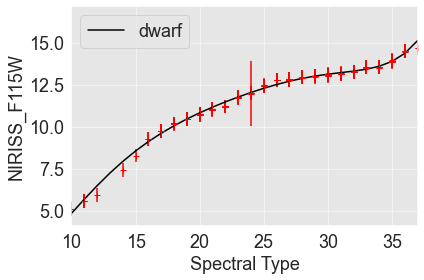

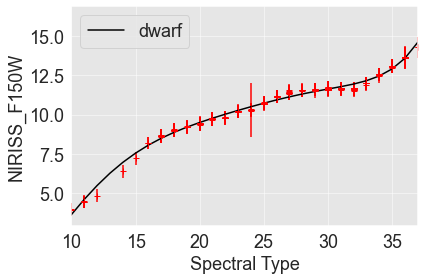

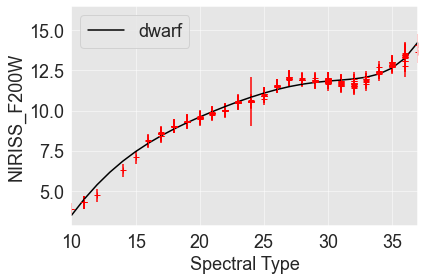

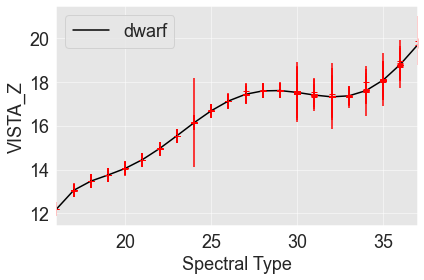

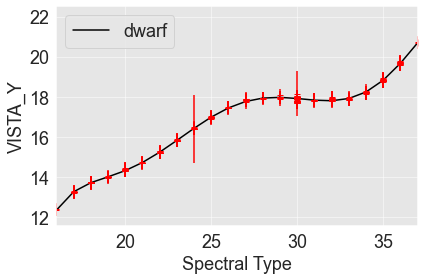

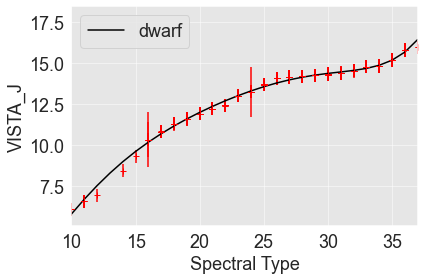

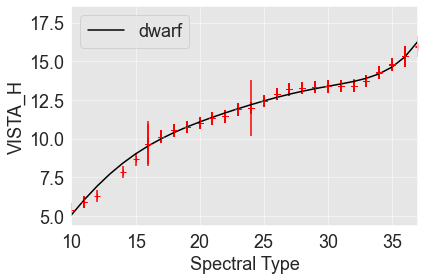

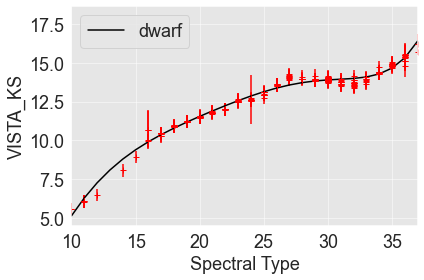

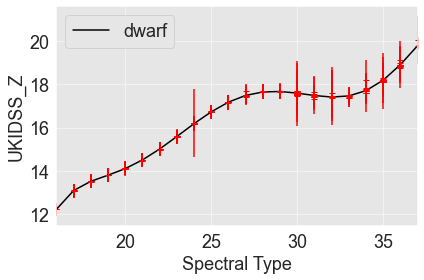

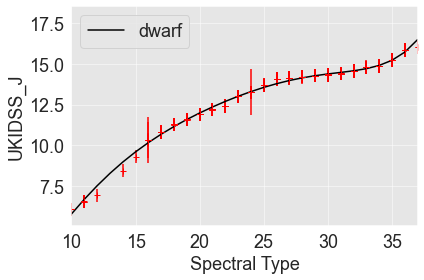

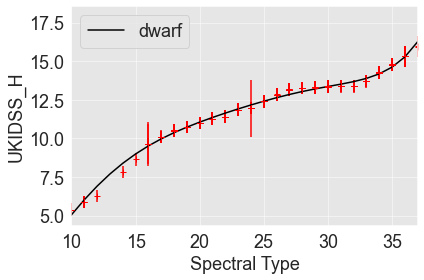

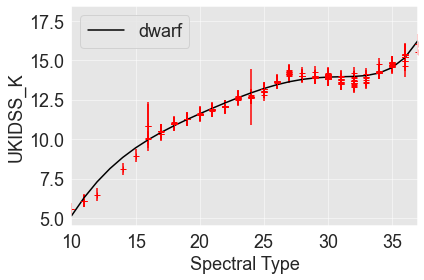

In [86]:
for c in abs_df.columns:
    try:
        if c=='spt':
            pass
        else:
            fig, a=plt.subplots()
            vals=np.vstack(abs_df[c].values)
            #vals=np.vstack(sd_abs_df[c].values)
            spts=df.spt.values
            #spts=sd_df.spt.values

            #masks
            mask= np.logical_or.reduce([np.isnan(spts), 
                                        np.isnan(vals[:,0]),
                                        np.isnan(vals[:,1])])

            m, fit= fit_with_nsigma_clipping(spts[~mask], 
                                          vals[:,0][~mask], 
                                          vals[:,1][~mask], 6, sigma=3.)
            FITS['absmags']['dwarfs'].update({c: {'x': 'spt',
                                                  'y': c,
                                                  'fit':fit, \
                                                  'scatter': np.nanmedian(vals[:,1]), \
                                                  'method': 'polynomial',\
                                                  'range':  (np.nanmin(spts[~mask]),\
                                                             np.nanmax(spts[~mask])), \
                                                 'x0':0}})


            spgrid=np.arange(np.nanmin(spts[~mask]), np.nanmax(spts[~mask]))
            a.plot(spgrid, fit(spgrid), c='k', label='dwarf')



            a.errorbar(spts, vals[:,0], fmt='+', 
                       yerr=vals[:,1], color='r')



            a.set_ylabel(c)
            a.set_xlabel('Spectral Type')
            a.legend()
            plt.tight_layout()
            a.set_xlim([np.nanmin(spgrid), np.nanmax(spgrid)])
            #a.set_ylim([fit(np.nanmin(spgrid)), fit(np.nanmax(spgrid))])
            plt.savefig('../figures/abs_mag_relations{}.pdf'.format(c))
    except:
        print ('all empty {}'.format(c))
        pass 


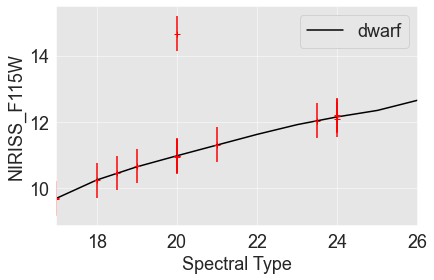

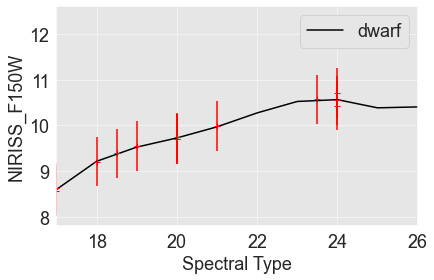

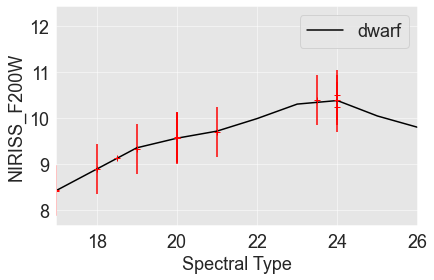

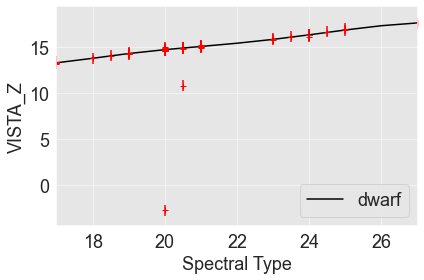

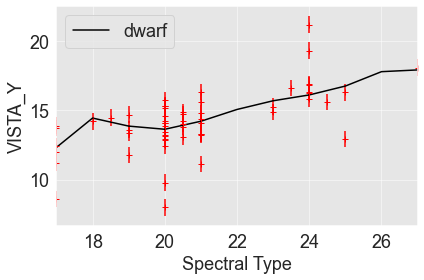

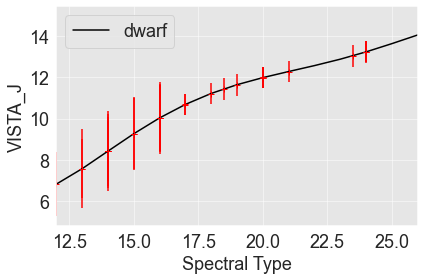

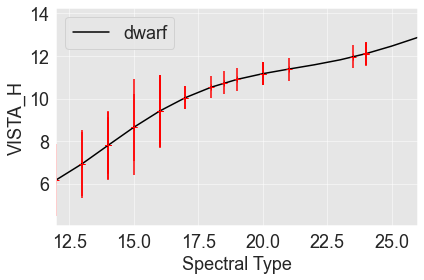

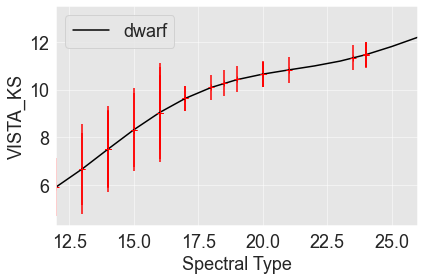

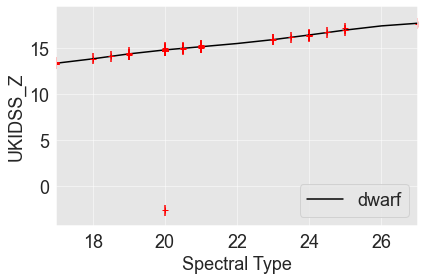

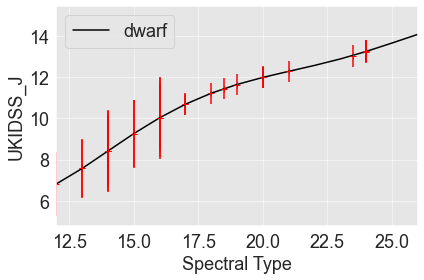

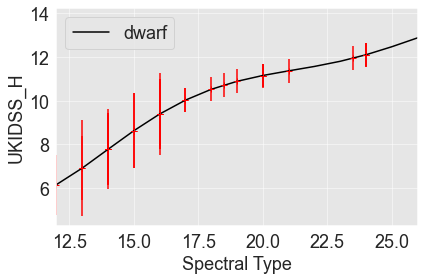

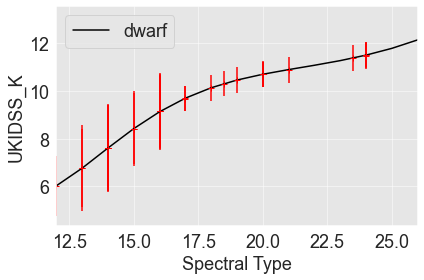

In [87]:
for c in sd_abs_df.columns:
    try:
        if c=='spt':
            pass
        else:
            fig, a=plt.subplots()
            vals=np.vstack(sd_abs_df[c].values)
            spts=sd_df.spt.values

            #masks
            mask= np.logical_or.reduce([np.isnan(spts), 
                                        np.isnan(vals[:,0]),
                                        np.isnan(vals[:,1])])

            m, fit= fit_with_nsigma_clipping(spts[~mask], 
                                          vals[:,0][~mask], 
                                          vals[:,1][~mask], 6, sigma=3.)
            FITS['absmags']['subdwarfs'].update({c: {'x': 'spt',
                                                  'y': c,
                                                  'fit':fit, \
                                                  'scatter': np.nanmedian(vals[:,1]), \
                                                  'method': 'polynomial',\
                                                  'range':  (np.nanmin(spts[~mask]),\
                                                             np.nanmax(spts[~mask])), \
                                                 'x0':0}})


            spgrid=np.arange(np.nanmin(spts[~mask]), np.nanmax(spts[~mask]))
            a.plot(spgrid, fit(spgrid), c='k', label='dwarf')



            a.errorbar(spts, vals[:,0], fmt='+', 
                       yerr=vals[:,1], color='r')



            a.set_ylabel(c)
            a.set_xlabel('Spectral Type')
            a.legend()
            plt.tight_layout()
            a.set_xlim([np.nanmin(spgrid), np.nanmax(spgrid)])
            #a.set_ylim([fit(np.nanmin(spgrid)), fit(np.nanmax(spgrid))])
            plt.savefig('../figures/abs_mag_relations{}_sd.pdf'.format(c))
    except:
        print ('all empty {}'.format(c))
        pass 


In [88]:
#abs_df.keys()

In [89]:
#def fit_nsigma():
#    return 

In [90]:
#POLYNOMIALS=FITS

In [91]:
#ir=np.vstack(abs_df.LSST_I)[:,0]-np.vstack(abs_df.LSST_R)[:,0]

In [92]:
#h=plt.hist(ir)

In [93]:
#e(spts_m, d=np.ones_like(spts_m)*1000, keys=['LSST_Z', 'LSST_R'], object_type='dwarfs')

In [94]:
#updating WISE
#wise_dict=splat.SPT_ABSMAG_RELATIONS['best2018']['filters']['WISE_W1']
#_, fit_2massk=fit_with_nsigma_clipping(np.array(KVALS['2MASS_KS']['spt']), 
#                                      np.array( KVALS['2MASS_KS']['values']), 
#                                      np.array( KVALS['2MASS_KS']['rms'])
#                                     , 6, sigma=5.)
#add wise relations

#_, fit_wise1=fit_with_nsigma_clipping(np.array(wise_dict['spt']), 
#                                      np.array( wise_dict['values']), 
#                                      np.array( wise_dict['rms'])
#                                     , 6, sigma=5.)
#            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
#            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
#            'rms': np.zeros(65)+0.05}})

In [95]:
#df.spt.values.min()

In [96]:
#get_kirkpatrick_wise(30-10)

In [97]:
#spts_grids=np.linspace(17, 44, 1000)
#w1s=np.array([get_kirkpatrick_wise(x) for x in spts_grids])

In [98]:
#_, fit_wise=fit_with_nsigma_clipping(np.array(spts_grids), 
#                                      np.array(w1s), 
#                                      np.ones(len(w1s))*0.63
#                                     , 6, sigma=5.)
#plt.plot(spts_grids, w1s)
#plt.plot(spts_grids,fit_wise(spts_grids) )


In [99]:
#vals=np.vstack(abs_df['WFC3_F160W'].values)
#spts=df.spt.values
#plt.plot(spts, vals[:,0], 'o')

In [100]:
#FITS['2MASS_K']=(fit_2massk, np.nanmedian(np.array( KVALS['2MASS_KS']['rms'])))
#FITS['WISE_W1']=(fit_wise, 0.63)

In [101]:
#FITS['absmags']['subdwarfs']={}

In [102]:
import pickle
output = open(ABS_MAG_FILE, 'wb')
pickle.dump(FITS, output)
output.close()

In [103]:
#FITS

In [104]:
#FITS['references']['kiman2019']